In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt

In [2]:
ds = load_dataset("ylecun/mnist")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  
])

In [4]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]["image"], self.dataset[idx]["label"]
        if self.transform:
            image = self.transform(image)
        return {"image": image, "label": label}

In [5]:
test_dataset = MNISTDataset(ds["test"], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
        )

        self.decoder = nn.Sequential(
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = AutoEncoder().to(device)

In [12]:
checkpoint_path = "autoencoder.pth" 
trained_model.load_state_dict(torch.load(checkpoint_path))
trained_model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [19]:
def test_autoencoder(model, test_loader, device, num_batches=5, num_images_per_batch=5):
    model.eval()
    batch_count = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch["image"].to(device).float()
            inputs_flat = inputs.view(inputs.size(0), -1)
            outputs = model(inputs_flat)
            outputs_reshaped = outputs.view(inputs.size(0), 1, 28, 28)
            for i in range(min(num_images_per_batch, inputs.size(0))):
                fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                axs[0].imshow(inputs[i].cpu().squeeze(), cmap="gray")
                axs[0].set_title("Original Image")
                axs[0].axis("off")
                axs[1].imshow(outputs_reshaped[i].cpu().squeeze(), cmap="gray")
                axs[1].set_title("Reconstructed Image")
                axs[1].axis("off")
                plt.tight_layout()
                plt.show()
            batch_count += 1
            if batch_count >= num_batches:
                break

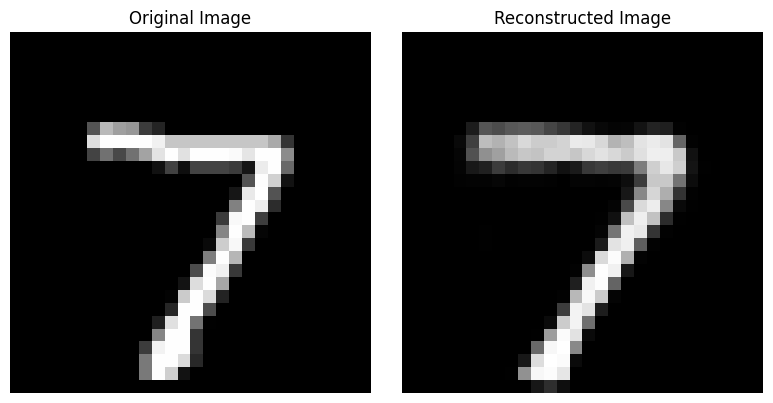

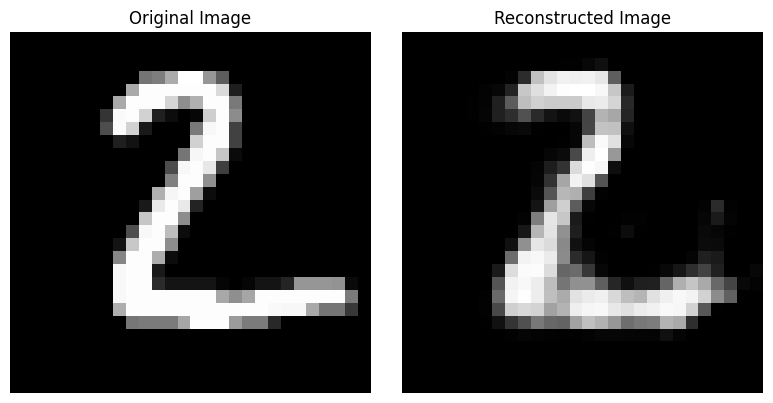

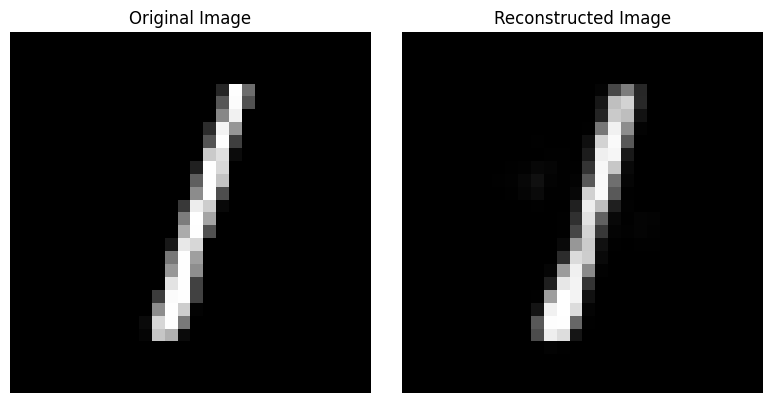

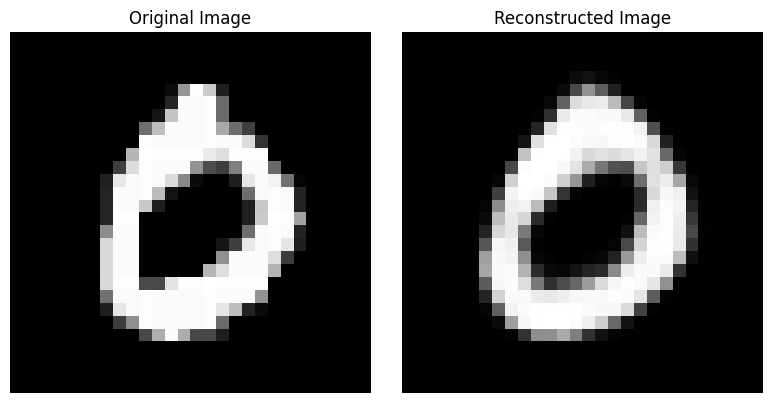

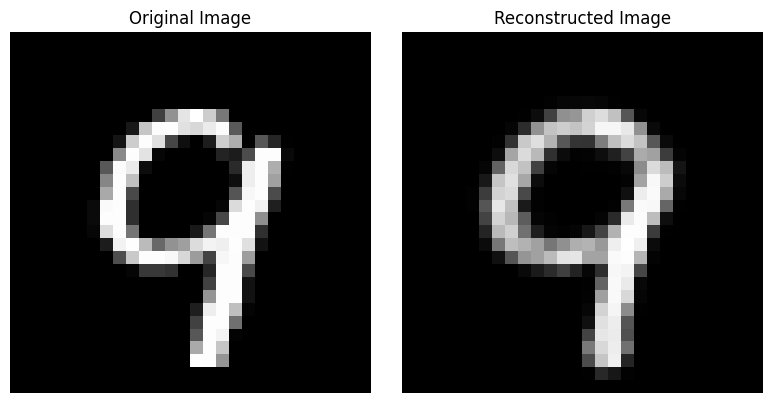

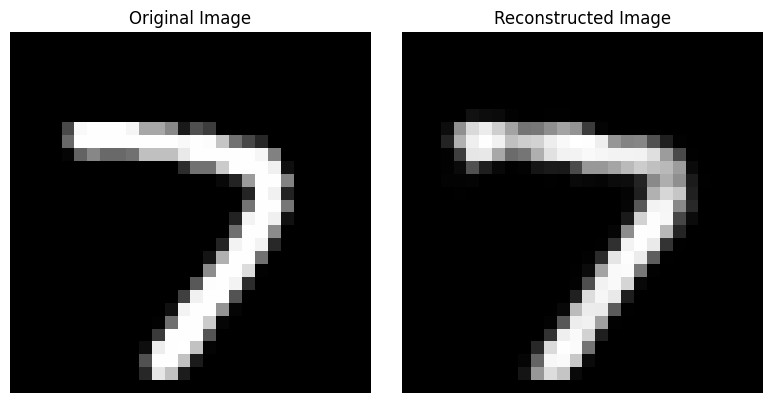

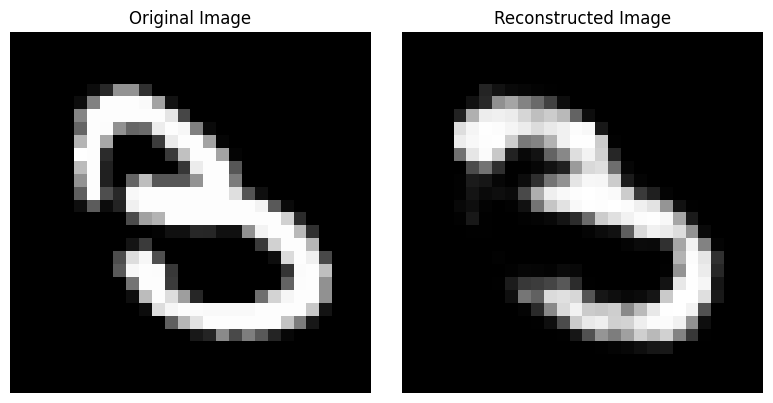

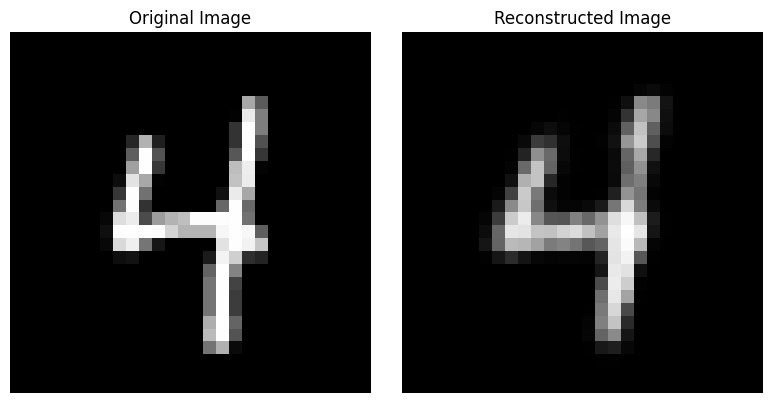

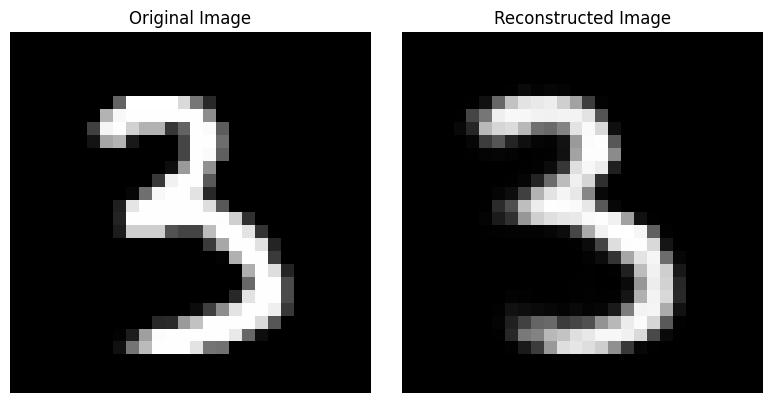

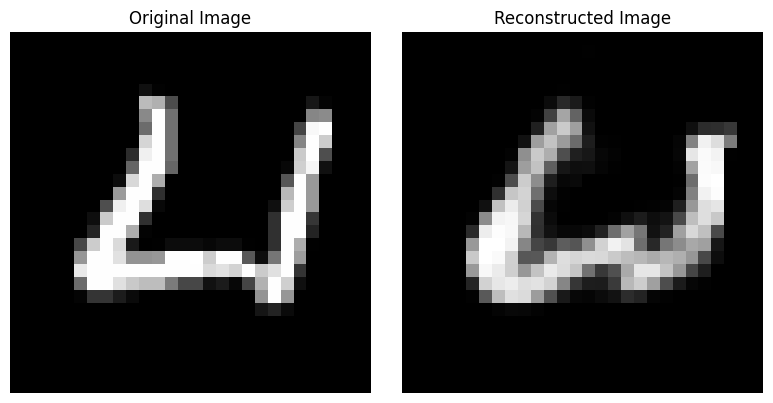

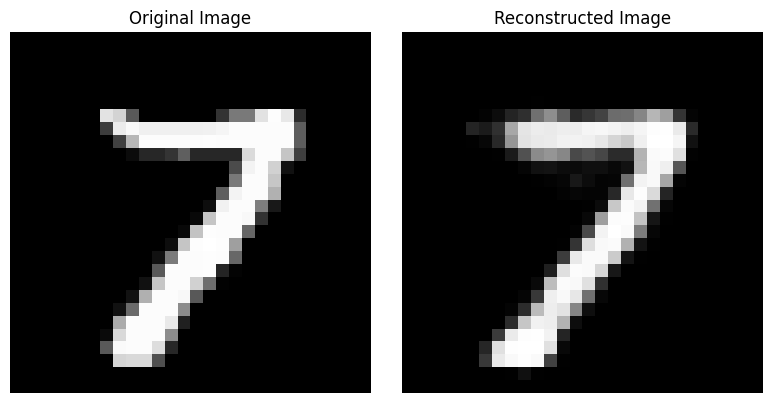

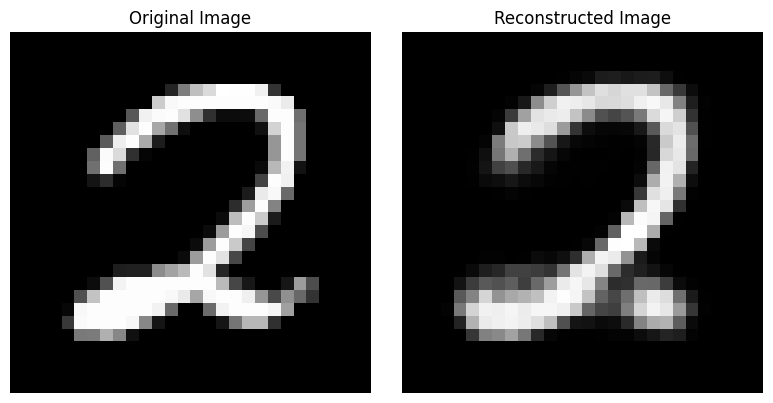

In [21]:
test_autoencoder(trained_model, test_loader, device, num_batches=3, num_images_per_batch=4)